<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/pontfelh%C5%91_metszete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pontfelhő metszete saját python szkripttel

Pontfelhő vízszintes vagy függőleges síkkal történp metszése igen gyakori feladat ma a geodéziában és térinformatikában. Számos szoftverrel megoldható, az első próbálkozásokhoz javasoljuk a nylít forráskódú [CloudCompare](https://www.danielgm.net/cc/) szoftvert, amelynek grafikus és parancssori felületét egyaránt használhatjuk.

Első lépésben a pontfelhőnket töltsük be egy numpy tömbbe. A fájlban UTM vetületen keleti és északi koordináták, illetve tengerszint feletti magasság található. A mezőket vesszők választják el egymástól, a fájlnak nincs fejléce. A fájl a github oldalunkon érhető el, onnan is közvetlenül betölthető.

In [1]:
import numpy as np
pc = np.loadtxt('https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/lidar.txt', delimiter=',')

Nézzük meg a beolvasott pontok számát, valamint a magasságok minimális, illetve maximális értékeit.

In [2]:
pc.shape[0], np.min(pc[:,2]), np.max(pc[:,2])

(51150, 933.31, 1139.11)

A vízszintes síkkal történő metszés valójában egy szűrés a magasságokra. Ehhez meg kell adni a metszetsík magasságát, valamint egy tolerancia értéket.

In [3]:
tol = 1 # tolerancia
coo = 1100 # a metszetsík magassága
sec = pc[np.absolute(pc[:, 2] - coo) < tol]

Nézzük meg a metszetbe eső pontok számát.

In [4]:
sec.shape[0]

896

Majd nézzük meg a metszetbe eső pontokat egy felülnézeti ábrán a matplotlib modul segítségével.

Text(0.5, 1.0, 'metszet 1100 m magasságban')

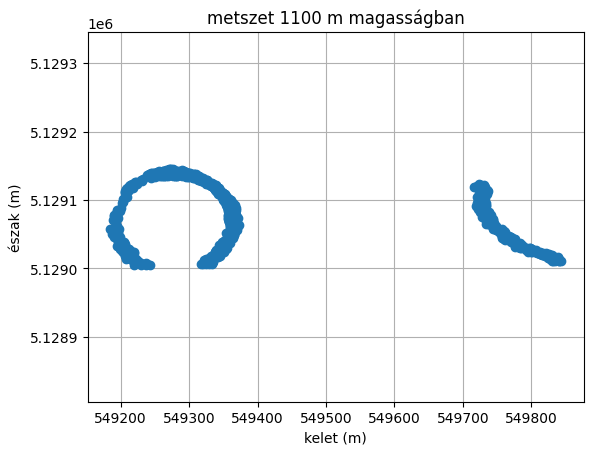

In [5]:
import matplotlib.pyplot as plt
plt.plot(sec[:,0], sec[:,1], 'o')
plt.xlabel('kelet (m)')
plt.ylabel('észak (m)')
plt.axis('equal')
plt.grid('on')
plt.title('metszet ' + str(coo) + ' m magasságban')

Ezután messük el a pontfelhőt egy függőleges síkkal. A függőleges síkot két pontjával definiálhatjuk.

In [7]:
y1 = 549400; x1 = 5128900 # a metszetvonal kezdőpontja, geodéziai y és x
y2 = 549200; x2 = 5129300 # a metszetvonal végpontja

Definiáljunk egy függvényt, ami a metszetvonal kezdő és végpontjának koordinátáiból megadja az egyenes irányvonalas egyenletének együtthatóit.

In [8]:
from math import hypot
def vplain(x1, y1, x2, y2):
  """ egyenes irányvonalas egyenlete, matematika x és y
  vp[0] * x + vp[1] * y + vp[2] = 0

  x1, y1 - metszetvonal kezdőpontjának koordinátái
  x2, y2 - metszetvonal végpontjának koordinátái
  az eredmény egy numpy tömb az együtthatókkal
  """

  vp = np.zeros((3,))
  vp[0] = y1 - y2
  vp[1] = x2 - x1
  vp[2] = x1 * y2 - x2 * y1
  vp = vp / hypot(vp[0], vp[1]) # normalizálás
  return vp

vplain(y1, x1, y2, x2)

array([-8.94427191e-01, -4.47213595e-01,  2.78511211e+06])

Az együtthatókat tartalmazó vektort szorozva a pontfelhő pontjait tartalmazó tömbbel kapjuk a pontfelhő pontjainak egyenestől vett előjeles távolságát. Az előjel azt adja meg, hogy a pont az egyenes jobb vagy baloldalán található.

In [9]:
def section(pc, x1, y1, x2, y2, tol):
  """ pontfelhő metszete függőleges síkkal

  pc - pontfelhő numpy tömbben
  x1, y1 - metszetvonal kezdőpontjának koordinátái
  x2, y2 -  metszetvonal végpontjának koordinátái
  tol - tolerancia
  az eredmény egy numpy tömb a metszetsíkba adott tolerancián belül eső pontokkal
  """
  pc1 = pc.copy()
  pc1[:, 2] = 1 # áttérés homogén koordinátákra
  vp = vplain(x1, y1, x2, y2) # az egyenes egyenletének együtthatói
  sec = pc[np.abs(np.dot(pc1, vp)) < tol] # vektoriális szorzás, majd szűrés

  return sec

Hívjuk meg a függvényt és nézzük meg a metszetbe eső pontok számát.

In [11]:
sec = section(pc, y1, x1, y2, x2, tol)
sec.shape[0]

96

Ábrázoljuk a pontokat felülnézetben.

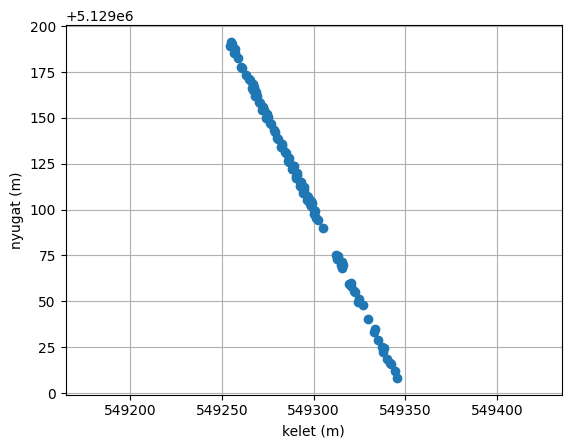

In [12]:
plt.plot(sec[:,0], sec[:,1], 'o')
plt.xlabel('kelet (m)')
plt.ylabel('nyugat (m)')
plt.axis('equal')
plt.grid('on')

Ezután nézzük meg a metszetbe eső pontokat a metszetsík definiálta nézetben (keresztmetszetben). Ehhez transzformálnunk kell a pontokat. A transzformáció egyrészt egy eltolás a metszetvonal kezdőpontjára, majd eg forgatás a metszetvonal irányszögével. A transzformációs függvényt az alábbi módon definiáljuk.

In [13]:
def tr(y1, x1, y2, x2):
  """ transzformációs mátrix felvétele

  Paraméterek:
  y1, x1 - metszetvonal kezdőpontjának koordinátái
  y2, x2 - metszetvonal végpontjának koordinátái
  az eredmény a transzformációs mátrix
  """
  dy = y2 - y1
  dx = x2 - x1

  d = hypot(dy, dx) # distance
  r = dy / d # sin
  m = dx / d # cos
  return np.dot(np.array([[1, 0, 0], [0, 1, 0], [-y1, -x1, 1]]),
                np.array([[m, r, 0], [-r, m, 0], [0, 0, 1]]))


Alkalmazzuk a transzformációt a metszetsíkba eső pontokra.

In [14]:
# transzformációs mátrix
trm = tr(y1, x1, y2, x2)
# másolat homogén koordinátákhoz
pc1 = sec.copy()
pc1[:, 2] = 1
pc1 = np.dot(pc1, trm) # transzformáció
pc1[:, 2] = sec[:, 2] # magasságok visszamásolása

Nézzük meg a metszetet.

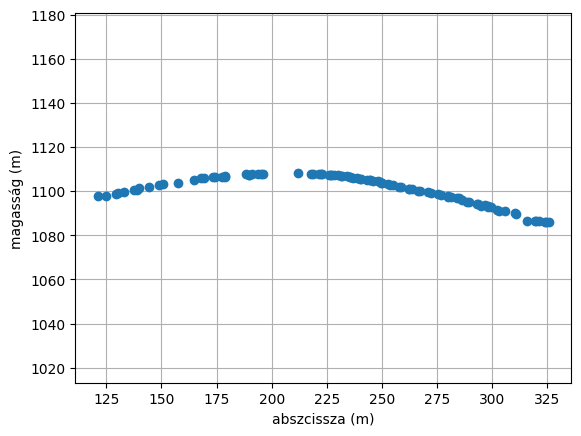

In [15]:
plt.plot(pc1[:,1], pc1[:,2], 'o')
plt.xlabel('abszcissza (m)')
plt.ylabel('magasság (m)')
plt.axis('equal')
plt.grid('on')